<a href="https://colab.research.google.com/github/IvanNeverov/PersonalTDA/blob/main/TDA_1_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-02-26 05:42:03--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-02-26 05:42:04 (650 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [101]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \
!pip3 install psycopg2-binary
!pip3 install catboost

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu 

In [4]:
# import psycopg2

# conn = psycopg2.connect("""
#     host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
#     port=6432
#     sslmode=verify-full
#     dbname=db_clients
#     user=mlhs_student
#     password=mlhs_student
#     target_session_attrs=read-write
# """)

##Загрузка данных

In [7]:
import pandas as pd
df = pd.read_csv('/content/deposits_data.csv')

##Обработка

In [8]:
# df.head()
df.info()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [9]:
df.deposit.value_counts()
df.default = df.default.map(dict(no = 0, yes=1))
df.housing = df.housing.map(dict(no = 0, yes=1))
df.loan = df.loan.map(dict(no = 0, yes=1))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  int64 
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  int64 
 7   loan       11162 non-null  int64 
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(10), object(7)
memory usage: 1.4+ MB


In [10]:
df.drop_duplicates(inplace = True)


In [11]:
df.deposit.value_counts() 

no     5873
yes    5289
Name: deposit, dtype: int64

In [12]:
df.groupby('deposit').mean()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous
deposit,,,,,,,,,,
no,40.837391,0.019751,1280.227141,0.569726,0.166184,16.108122,223.130257,2.839264,35.685340,0.528350
yes,41.670070,0.009832,1804.267915,0.365854,0.091511,15.158253,537.294574,2.141047,68.702968,1.170354


<AxesSubplot:xlabel='job'>

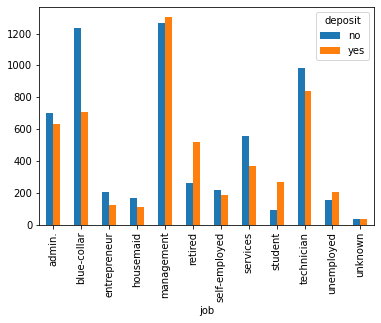

In [13]:
pd.crosstab(df.job,df.deposit).plot(kind='bar')

<AxesSubplot:xlabel='education'>

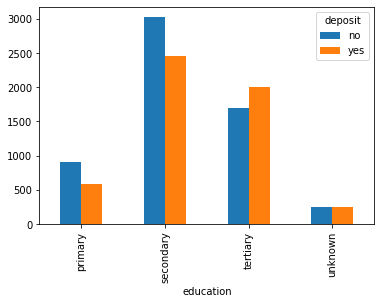

In [14]:
pd.crosstab(df.education,df.deposit).plot(kind='bar')

<AxesSubplot:xlabel='contact'>

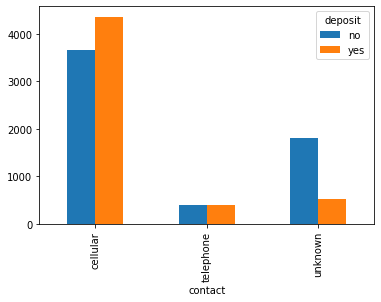

In [15]:
pd.crosstab(df.contact,df.deposit).plot(kind='bar')

<AxesSubplot:xlabel='marital'>

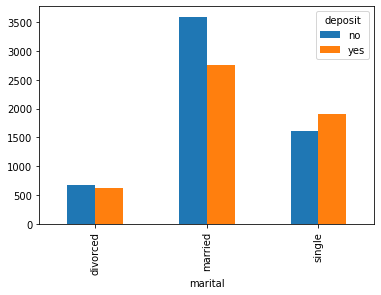

In [16]:
pd.crosstab(df.marital,df.deposit).plot(kind='bar')

In [17]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous
age,1.000000,-0.011425,0.112300,-0.168700,-0.031418,-0.000762,0.000189,-0.005278,0.002774,0.020169
default,-0.011425,1.000000,-0.060954,0.011076,0.076434,0.017342,-0.009760,0.030975,-0.036282,-0.035273
balance,0.112300,-0.060954,1.000000,-0.077092,-0.084589,0.010467,0.022436,-0.013894,0.017411,0.030805
housing,-0.168700,0.011076,-0.077092,1.000000,0.076761,-0.014770,0.035051,0.006660,0.064497,-0.000840
loan,-0.031418,0.076434,-0.084589,0.076761,1.000000,0.017269,-0.001914,0.034722,-0.030416,-0.022668
day,-0.000762,0.017342,0.010467,-0.014770,0.017269,1.000000,-0.018511,0.137007,-0.077232,-0.058981
duration,0.000189,-0.009760,0.022436,0.035051,-0.001914,-0.018511,1.000000,-0.041557,-0.027392,-0.026716
campaign,-0.005278,0.030975,-0.013894,0.006660,0.034722,0.137007,-0.041557,1.000000,-0.102726,-0.049699
pdays,0.002774,-0.036282,0.017411,0.064497,-0.030416,-0.077232,-0.027392,-0.102726,1.000000,0.507272
previous,0.020169,-0.035273,0.030805,-0.000840,-0.022668,-0.058981,-0.026716,-0.049699,0.507272,1.000000


## Построение модели

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(['deposit','job','marital','contact','poutcome','education','month'], axis =1)
Y = df.deposit

Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,test_size=0.25, random_state=42)

ss= StandardScaler()
ss.fit(Xtrain)

model = LogisticRegression()
model.fit(Xtrain,Ytrain)

LogisticRegression()

In [29]:
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_score, roc_auc_score
prediction = model.predict(Xtest)
accuracy_score(Ytest,prediction)

0.7549265496237908

In [55]:
pred_df = pd.DataFrame({'Prediction':prediction})
pred_df.Prediction[pred_df['Prediction'] == 'no'], pred_df.Prediction[pred_df['Prediction'] == 'yes'] = 0,1
Ytest_form = pd.DataFrame({'Fact':Ytest}) 
Ytest_form.Fact[Ytest_form['Fact'] == 'no'], Ytest_form.Fact[Ytest_form['Fact'] == 'yes'] = 0,1
Ytest_form.value_counts()

Fact
0       1450
1       1341
dtype: int64

In [38]:
mtrx = confusion_matrix(Ytest,prediction)
mtrx

array([[1450,    0],
       [   0, 1341]])

In [67]:
recall_score(Ytest,prediction, pos_label='no')

0.7951724137931034

In [68]:
precision_score(Ytest,prediction, pos_label='no')

0.7487012987012988

In [60]:
Probs = model.predict_proba(Xtest)
Probs[:15] #все ок сбалансировано

array([[0.66716084, 0.33283916],
       [0.02044097, 0.97955903],
       [0.35212515, 0.64787485],
       [0.07955404, 0.92044596],
       [0.87479258, 0.12520742],
       [0.34769357, 0.65230643],
       [0.70967968, 0.29032032],
       [0.84291152, 0.15708848],
       [0.45921967, 0.54078033],
       [0.11260388, 0.88739612],
       [0.38952752, 0.61047248],
       [0.84576521, 0.15423479],
       [0.39007761, 0.60992239],
       [0.29278168, 0.70721832],
       [0.24856523, 0.75143477]])

In [ ]:
roc_auc_score(Ytest,Probs[:,1])

In [24]:
model.coef_, model.intercept_
coefs = pd.DataFrame( {'features':list(X.columns),'weights': list(model.coef_[0])})
coefs

,features,weights
0,age,-0.016790
1,default,-0.029444
2,balance,0.000034
3,housing,-0.969108
4,loan,-0.266718
5,day,-0.016510
6,duration,0.004587
7,campaign,-0.121285
8,pdays,0.000577
9,previous,0.347137


##KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(weights='uniform')

knn.fit(Xtrain, Ytrain)
knn_pred = knn.predict(Xtest)
confusion_matrix(Ytest,knn_pred)

array([[1115,  335],
       [ 369,  972]])

In [26]:
recall_score(Ytest,knn_pred, pos_label = 'no')

0.7689655172413793

In [27]:
precision_score(Ytest,knn_pred, pos_label = 'no')

0.7513477088948787

##Dummy variables

In [66]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  int64 
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  int64 
 7   loan       11162 non-null  int64 
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(10), object(7)
memory usage: 1.5+ MB


In [82]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

Xtrain, Xtest, ytrain, ytest = train_test_split(df.drop('deposit', axis=1), df.deposit, test_size=0.25, random_state=42)
X = df.drop(['deposit','job','marital','contact','poutcome','education','month'], axis =1)
categorical = ['job','marital','education','contact','month','poutcome']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), X.columns)
])

X_transformed = column_transformer.fit_transform(Xtrain)
X_test_transformed = column_transformer.transform(Xtest)

##Linear Regression with Dummies

In [86]:
model2 = LogisticRegression()
model2.fit(X_transformed,ytrain)
ohe_LgRg = model2.predict(X_test_transformed)
ohe_LgRg_proba = model2.predict_proba(X_test_transformed)

In [98]:
print('Precision',round(precision_score(Ytest,ohe_LgRg, pos_label = 'no'),2))
print('Recall',round(recall_score(Ytest,ohe_LgRg, pos_label = 'no'),2))
print('ROC AUC',round(roc_auc_score(Ytest,ohe_LgRg_proba [:,1]),2))

Precision 0.8
Recall 0.84
ROC AUC 0.9


## Boost

In [115]:
from catboost import CatBoostClassifier, Pool

cat = CatBoostClassifier(iterations=1000,
                         depth = 3,
                         learning_rate = 0.01,
                         loss_function='Logloss',
                         eval_metric = 'AUC',
                         verbose=False)
cat.fit(X_transformed, ytrain)
ohe_boost = cat.predict(X_test_transformed)   
ohe_boost_proba = cat.predict_proba(X_test_transformed)   

In [116]:
print('Precision',round(precision_score(Ytest,ohe_boost, pos_label = 'no'),2))
print('Recall',round(recall_score(Ytest,ohe_boost, pos_label = 'no'),2))
print('ROC AUC',round(roc_auc_score(Ytest,ohe_boost_proba [:,1]),2))

Precision 0.85
Recall 0.83
ROC AUC 0.91
